### QUESTION 4: 

Design a regression model using any features from the papers you find or other new features you may find useful for this problem. Fit your model on the data of each hashtag and report fitting MSE and significance of features.

#### Ans:

We will consider below features:

* Average impressions = total impressions / total tweets (for a particular hour)
* Average ranking score = total ranking / total tweets (for a particular hour)
* Average User Passivity(for original user) = total passivity / total tweets (for a particular hour)

In [1]:
hash_tags = ['#gohawks','#gopatriots','#nfl','#patriots','#sb49','#superbowl']

In [2]:
import pickle

def save_object(data, fileName):
    with open('pynb_data/'+fileName + ".pickle", 'wb') as f:
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
        
def load_object(fileName):
    try:
        with open('pynb_data/'+fileName + ".pickle", 'rb') as f:
            data = pickle.load(f)
            return data
    except IOError:
        print("Could not read file: " + fileName)

In [3]:
import json

def getMinAndMaxTs(tag):
    filename = 'data/tweets_'+tag+'.txt'
    max_ts = 0
    min_ts = 1552522378
    with open(filename) as f:
        for line in f:
            json_object = json.loads(line)
            timestamp = json_object['citation_date']
            if(timestamp < min_ts):                
                min_ts = timestamp
            
            if(timestamp > max_ts):
                max_ts = timestamp
                
    return [min_ts,max_ts]

tagsToMinTs = {}
tagsToMaxTs = {}
for tag in hash_tags:
    ts_list = getMinAndMaxTs(tag)
    tagsToMinTs[tag] = (ts_list[0])
    tagsToMaxTs[tag] = (ts_list[1])    

In [10]:
import math
from datetime import date, timedelta
import datetime
import pytz
import json


def getLocalHour(timestamp):
    d = datetime.datetime.fromtimestamp(timestamp)
    pst = pytz.timezone('America/Los_Angeles')
    d = pst.localize(d)
    return d.hour

def getWindowNumber(start_ts, curr_ts, window):
    elapsed = (curr_ts - start_ts)/(window*1.0)
    windowNum = math.ceil(elapsed)
    return windowNum    

#https://stackoverflow.com/questions/2315032/how-do-i-find-missing-dates-in-a-list-of-sorted-dates
def getAllDays(dayStrList):
    dayList = [ datetime.datetime.strptime(x, '%Y:%m:%d') for x in dayStrList ]    
    irange = [i for i in range((dayList[-1] - dayList[0]).days)]
    irange.append(irange[-1]+1)    
    allDaysList = sorted(list(set(dayList[0] + timedelta(x) for x in irange)))
    allDayStrList = [ ('{}:{}:{}'.format(d.year,d.month,d.day)) for d in allDaysList ]
    return allDayStrList

# https://arxiv.org/pdf/1401.2018v2.pdf
def getUserPassivity(user,ts):
    createdDateTimeObj = datetime.datetime.strptime(user['created_at'],"%a %b %d %H:%M:%S %z %Y")
    created = datetime.datetime.fromtimestamp(createdDateTimeObj.timestamp())
    d = datetime.datetime.fromtimestamp(ts)
    td = (created - d).days
    statuses_count = user['statuses_count']
    return td/(1.0+statuses_count)
    
def getFeatures(tag,start_ts,end_ts,window):
    windowToTweets = {}
    windowToRetweets = {}
    windowToFollowerCount = {}
    windowToMaxFollowers = {}
    windowToRankingMetricSum = {}
    windowToImpressionsMetricSum = {}
    windowToUserPassivitySum= {}
    features = []
    labels = []
    
    filename = 'data/tweets_'+tag+'.txt'
    with open(filename) as f:
        for line in f:
            json_object = json.loads(line)
            timestamp = json_object['citation_date']
            
            if timestamp < start_ts or timestamp > end_ts:                            
                continue
                
            key = getWindowNumber(start_ts,timestamp,window)

            if key not in windowToTweets.keys():
                windowToTweets[key]=0
            windowToTweets[key]+=1
            
            retweetCount = json_object['metrics']['citations']['total']        
            
            if key not in windowToRetweets.keys():
                windowToRetweets[key]=0
            windowToRetweets[key]+=retweetCount
        
            followerCount = json_object['author']['followers']
            if key not in windowToFollowerCount.keys():
                windowToFollowerCount[key]=0
            windowToFollowerCount[key]+=followerCount
            
            if key not in windowToMaxFollowers.keys():
                windowToMaxFollowers[key]=0
            windowToMaxFollowers[key] = max(windowToMaxFollowers[key],followerCount)
            
            if key not in windowToUserPassivitySum.keys():
                windowToUserPassivitySum[key]=0.0
            windowToUserPassivitySum[key]+=getUserPassivity(json_object['tweet']['user'],timestamp)
            
            if key not in windowToRankingMetricSum.keys():
                windowToRankingMetricSum[key]=0.0
            windowToRankingMetricSum[key]+=json_object['metrics']['ranking_score']
            
            if key not in windowToImpressionsMetricSum.keys():
                windowToImpressionsMetricSum[key]=0.0
            windowToImpressionsMetricSum[key]+=json_object['metrics']['impressions']
            
            
            
        for period in range(start_ts,end_ts,window):
            key = getWindowNumber(start_ts,period,window)

            tweetCount = windowToTweets.get(key, 0)
            retweetCount = windowToRetweets.get(key,0)
            followerCount = windowToFollowerCount.get(key,0)
            maxFollowers = windowToMaxFollowers.get(key,0)
            
            if tweetCount > 0:
                avgRanking = windowToRankingMetricSum.get(key,0)/tweetCount
                avgImpressions = windowToImpressionsMetricSum.get(key,0)/tweetCount
                avgUserPassivity = windowToUserPassivitySum.get(key,0)/tweetCount                
            else:
                avgRanking = 0
                avgImpressions = 0
                avgUserPassivity = 0
        
            h = getLocalHour(period)


            feature = [tweetCount, retweetCount, followerCount, maxFollowers, avgRanking,avgImpressions,avgUserPassivity, h]
            features.append(feature)
            nextKey = getWindowNumber(start_ts, period + window, window)
            labels.append(windowToTweets.get(nextKey,0))
                
    return features,labels

In [12]:
import math
import statsmodels.api as sm
import statsmodels.tools.eval_measures as ste

for tag in hash_tags:
    tp1_start_ts = 3600 * math.floor(tagsToMinTs[tag]/(3600*1.0))
    tp1_end_ts = 1553238024
    print("Started building feature vectors for {}".format(tag))
    features,labels = getFeatures(tag,tp1_start_ts,tp1_end_ts,3600)
    save_object(features,'q4features_{}'.format(tag))
    save_object(labels,'q4labels_{}'.format(tag))
    print("Finished building feature vectors for {}".format(tag))
    
    print('\nLinear Regression Model for {}'.format(tag))
    X_orig = features
    y = labels
    
    #     https://becominghuman.ai/stats-models-vs-sklearn-for-linear-regression-f19df95ad99b
    X = sm.add_constant(X_orig)
    
    model = sm.OLS(y,X)
    results = model.fit()
    pred_y = results.predict(X)

    print("\nMSE : {}".format(ste.mse(pred_y, y,axis=0)))
    print("\nMSE(from mse_resid) : {}".format(results.mse_resid))
    print("R-squared : {}".format(results.rsquared))    
    print("P values for the features are \n {} \n\n".format(results.pvalues))

    print(results.summary())
    print('---'*20)
    print('\n\n')

Started building feature vectors for #gohawks
Finished building feature vectors for #gohawks

Linear Regression Model for #gohawks

MSE : 11909.682075861572

MSE(from mse_resid) : 11912.605653819894
R-squared : 0.5070998468164205
P values for the features are 
 [4.89490080e-001 0.00000000e+000 2.61720144e-139 7.66543315e-084
 6.40414562e-001 3.33817558e-069 1.82907155e-021 1.07504818e-001
 4.27879324e-001] 


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     4715.
Date:                Fri, 22 Mar 2019   Prob (F-statistic):               0.00
Time:                        00:43:19   Log-Likelihood:            -2.2412e+05
No. Observations:               36672   AIC:                         4.483e+05
Df Residuals:                   36

Finished building feature vectors for #patriots

Linear Regression Model for #patriots

MSE : 82570.63688484093

MSE(from mse_resid) : 82590.90624992122
R-squared : 0.6806572559323453
P values for the features are 
 [8.64888907e-01 0.00000000e+00 4.22071462e-23 1.19378766e-06
 4.25786782e-49 1.05510918e-27 5.38458494e-26 8.72761007e-01
 8.60301425e-01] 


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     9768.
Date:                Fri, 22 Mar 2019   Prob (F-statistic):               0.00
Time:                        00:44:45   Log-Likelihood:            -2.5962e+05
No. Observations:               36672   AIC:                         5.193e+05
Df Residuals:                   36663   BIC:                         5.193e+05
Df Model: 

## Below box is old value(built using some arcane function)! Dont use this. (remove this cell after comparison)

In [6]:
import statsmodels.api as sm
import statsmodels.tools.eval_measures as ste

for tag in hash_tags:
    print('\nLinear Regression Model for {}'.format(tag))
#     X = load_object('q4features_{}'.format(tag))
#     y = load_object('q4labels_{}'.format(tag))
    
# #     https://becominghuman.ai/stats-models-vs-sklearn-for-linear-regression-f19df95ad99b
#     X = sm.add_constant(X)
    
#     model = sm.OLS(y,X)
#     results = model.fit()
#     pred_y = results.predict(X)
#     print("\nMSE : {}".format(ste.mse(pred_y, y,axis=0)))
#     print("R-squared : {}".format(results.rsquared))    
#     print("P values for the features are \n {} \n\n".format(results.pvalues))
#     print(results.summary())
#     print('---'*20)
#     print('\n\n')
    
#     print('\nLinear Regression Model for {}'.format(tag))
   
    X_orig = features
    y = labels
    
    #     https://becominghuman.ai/stats-models-vs-sklearn-for-linear-regression-f19df95ad99b
    X = sm.add_constant(X_orig)
    
    model = sm.OLS(y,X)
    results = model.fit()
    pred_y = results.predict(X)

    print("\nMSE : {}".format(ste.mse(pred_y, y,axis=0)))
    print("\nMSE(from mse_resid) : {}".format(results.mse_resid))
    print("R-squared : {}".format(results.rsquared))    
    print("P values for the features are \n {} \n\n".format(results.pvalues))

    print(results.summary())
    print('---'*20)
    print('\n\n')
    


Linear Regression Model for #gohawks

MSE : 825068.0463121694
R-squared : 0.47918645978420327
P values for the features are 
 [8.49085912e-01 2.48474038e-13 2.32296614e-03 1.94186167e-02
 9.03971515e-01 4.76450527e-01 2.88020696e-01 8.50946571e-01
 7.63431096e-01] 


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     59.69
Date:                Sat, 16 Mar 2019   Prob (F-statistic):           1.00e-68
Time:                        16:18:47   Log-Likelihood:                -4345.7
No. Observations:                 528   AIC:                             8709.
Df Residuals:                     519   BIC:                             8748.
Df Model:                           8                                         
Covariance Type:    

### QUESTION 5: 
For each of the top 3 features (i.e. with the smallest p-values) in your mea- surements, draw a scatter plot of predictant (number of tweets for next hour) versus value of that feature, using all the samples you have extracted, and analyze it.
Do the regression coefficients agree with the trends in the plots? If not, why?


Most important features(lowest p-values) for #gohawks
 retweetCount
 tweetCount
 followerCount
Pvalue for feature retweetCount for #gohawks is 2.617201444191593e-139
Coefficient for feature retweetCount for #gohawks is -0.1364923021365032


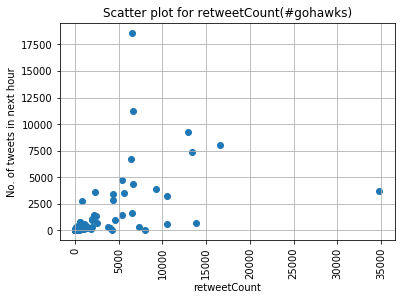

Pvalue for feature tweetCount for #gohawks is 0.0
Coefficient for feature tweetCount for #gohawks is 1.2978186974415102


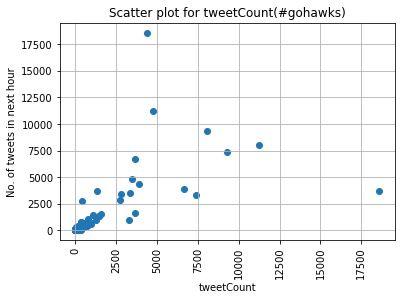

Pvalue for feature followerCount for #gohawks is 7.665433151216737e-84
Coefficient for feature followerCount for #gohawks is -0.000193366295320103


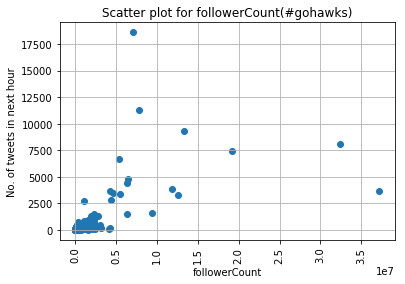

------------------------------------------------------------




Most important features(lowest p-values) for #gopatriots
 retweetCount
 tweetCount
 avgRanking
Pvalue for feature retweetCount for #gopatriots is 1.9904197089703886e-89
Coefficient for feature retweetCount for #gopatriots is 0.4792752171921195


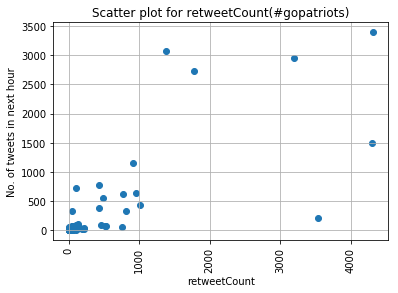

Pvalue for feature tweetCount for #gopatriots is 2.968087925339417e-18
Coefficient for feature tweetCount for #gopatriots is 0.309315223155896


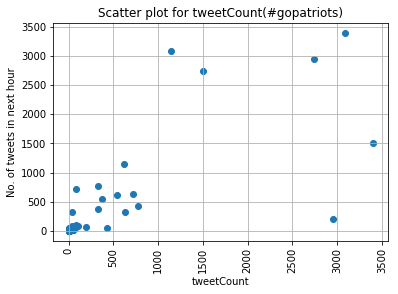

Pvalue for feature avgRanking for #gopatriots is 2.55061043585829e-16
Coefficient for feature avgRanking for #gopatriots is 1.9915861851892005


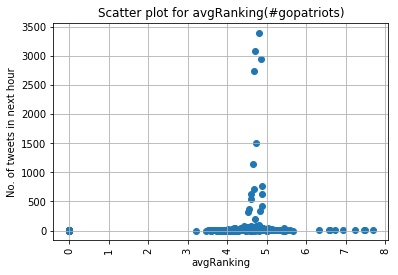

------------------------------------------------------------




Most important features(lowest p-values) for #nfl
 maxFollowers
 tweetCount
 followerCount
Pvalue for feature maxFollowers for #nfl is 6.438670199682634e-133
Coefficient for feature maxFollowers for #nfl is -0.0001175303897903271


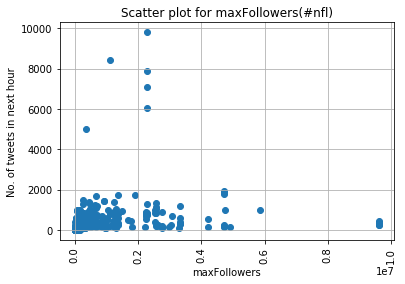

Pvalue for feature tweetCount for #nfl is 8.318505076841992e-219
Coefficient for feature tweetCount for #nfl is 0.5526059967624048


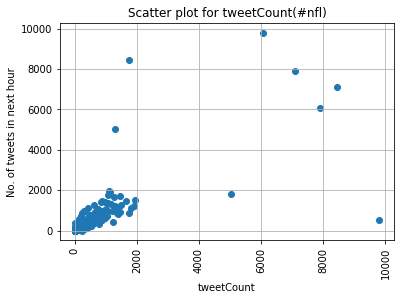

Pvalue for feature followerCount for #nfl is 9.404651213946918e-289
Coefficient for feature followerCount for #nfl is 0.00011687022181065563


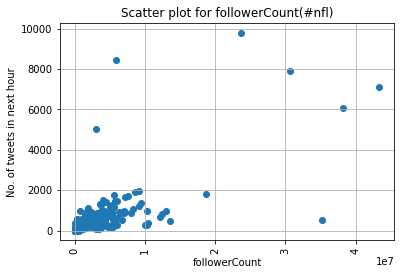

------------------------------------------------------------




Most important features(lowest p-values) for #patriots
 tweetCount
 avgRanking
 maxFollowers
Pvalue for feature tweetCount for #patriots is 0.0
Coefficient for feature tweetCount for #patriots is 0.9196176038946727


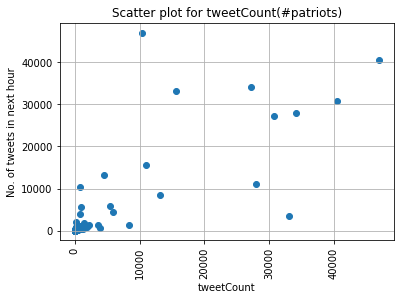

Pvalue for feature avgRanking for #patriots is 1.0551091812436166e-27
Coefficient for feature avgRanking for #patriots is 35.0496228418415


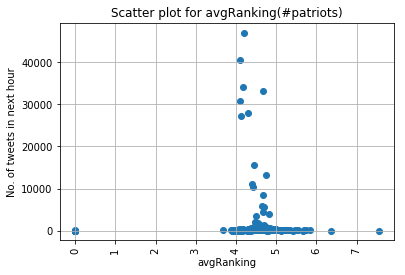

Pvalue for feature maxFollowers for #patriots is 4.257867822843651e-49
Coefficient for feature maxFollowers for #patriots is 0.0002030354081924519


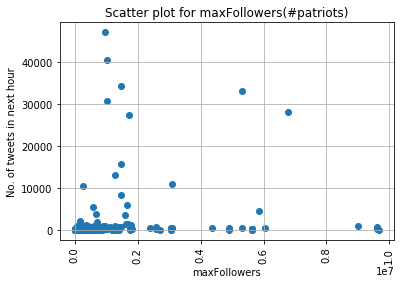

------------------------------------------------------------




Most important features(lowest p-values) for #sb49
 tweetCount
 maxFollowers
 retweetCount
Pvalue for feature tweetCount for #sb49 is 0.0
Coefficient for feature tweetCount for #sb49 is 1.1493262474275547


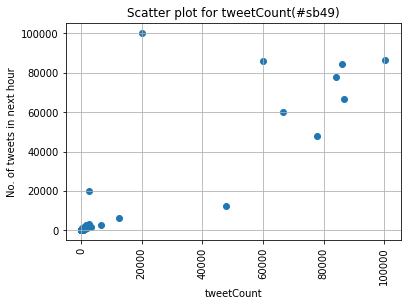

Pvalue for feature maxFollowers for #sb49 is 4.062766674757482e-87
Coefficient for feature maxFollowers for #sb49 is 0.00011947752177955578


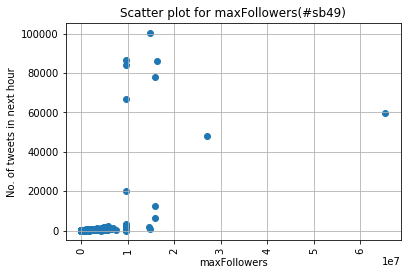

Pvalue for feature retweetCount for #sb49 is 5.669737574454274e-74
Coefficient for feature retweetCount for #sb49 is -0.1802789286981884


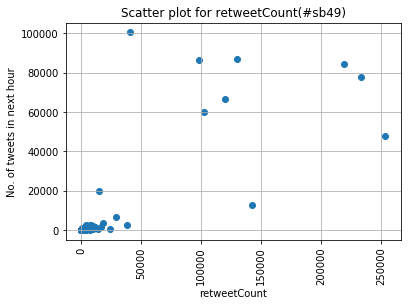

------------------------------------------------------------




Most important features(lowest p-values) for #superbowl
 followerCount
 tweetCount
 retweetCount
Pvalue for feature followerCount for #superbowl is 0.0
Coefficient for feature followerCount for #superbowl is -0.00014651957989197728


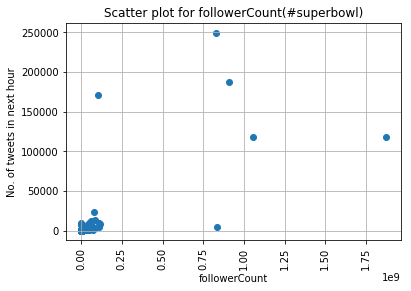

Pvalue for feature tweetCount for #superbowl is 0.0
Coefficient for feature tweetCount for #superbowl is 2.303764417539193


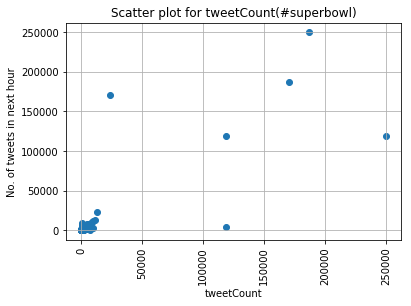

Pvalue for feature retweetCount for #superbowl is 0.0
Coefficient for feature retweetCount for #superbowl is -0.2485802314237501


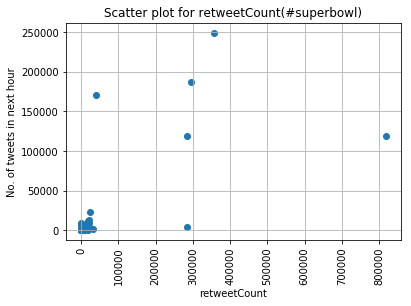

------------------------------------------------------------





In [13]:
import numpy as np
import matplotlib.pyplot as plt

index_to_feature = ['bias','tweetCount', 'retweetCount', 'followerCount', 'maxFollowers', 'avgRanking','avgImpressions','avgUserPassivity','hr']

def plotScatter(features,labels,index,tag):
    if index==0:
        return
    
    x = [f[index-1] for f in features]
    y = labels
    plt.scatter(x, y)
    plt.xlabel(index_to_feature[index])
    plt.xticks(rotation=90)
    plt.ylabel("No. of tweets in next hour")
    plt.title("Scatter plot for "+index_to_feature[index]+"("+tag+")")
    plt.grid()
    plt.show()

for tag in hash_tags:
    X_orig = load_object('q4features_{}'.format(tag))
    y = load_object('q4labels_{}'.format(tag))
    X = sm.add_constant(X_orig)

    model = sm.OLS(y,X)
    results = model.fit()
    a = np.array(results.pvalues)
#     print(results.params)
    
    ind = np.argpartition(a, 3)
    indices = ind[:3]

    print('\nMost important features(lowest p-values) for {}'.format(tag))
    for i in indices:    
        print(' '+index_to_feature[i])
        
    for i in indices:
        print("Pvalue for feature {} for {} is {}".format(index_to_feature[i],tag,results.pvalues[i]))
        print("Coefficient for feature {} for {} is {}".format(index_to_feature[i],tag,results.params[i]))
        plotScatter(X_orig,y,i,tag)
    
    print('---'*20)
    print('\n\n')
